In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, roc_auc_score, roc_curve, auc, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from tqdm.auto import tqdm

In [2]:
df_ = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [3]:
df = df_.copy()

Data Preparation

In [4]:
columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

Keep only the columns above

In [5]:
df = df[columns]

Lowercase the column names and replace spaces with underscores

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

Fill the missing values with 0

In [7]:
df = df.fillna(0)

Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

In [8]:
df['above_target'] = (df.msrp > df.msrp.mean()).astype(int)

In [9]:
df.drop('msrp', axis=1, inplace=True)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
X_train = df_train.drop('above_target', axis=1)
y_train = df_train.above_target.values

X_val = df_val.drop('above_target', axis=1)
y_val = df_val.above_target.values

### Q1: ROC AUC feature importance

In [13]:
numerical_variable = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64'] and col != 'year']

In [14]:
# roc auc score for numerical variable

def roc_auc_score_numerical_variable(df_train, numerical_variable):
    scores = []
    for col in numerical_variable:
        auc_score = roc_auc_score(df_train.above_target, df_train[col])
        scores.append((col, auc_score))
    return scores

In [15]:
scores = roc_auc_score_numerical_variable(df_train, numerical_variable)

In [16]:
for col, score in sorted(scores, key=lambda x: -x[1]):
    print(col, score)

engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.3669412128227987
city_mpg 0.3265755356754767


### Q2: Training the model

In [17]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

In [18]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [19]:
round(roc_auc_score(y_val, lr.fit(X_train, y_train).predict_proba(X_val)[:, 1]), 3)

0.976

### Q3: Precision and Recall

In [20]:
thresholds = np.linspace(0, 1, 101)

In [21]:
precision_list = []
recall_list = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (lr.predict_proba(X_val)[:, 1] >= t)
    predict_negative = (lr.predict_proba(X_val)[:, 1] < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    precision_list.append(precision)
    recall_list.append(recall)

C:\Users\PC\AppData\Local\Temp\ipykernel_23316\3048055623.py:16: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


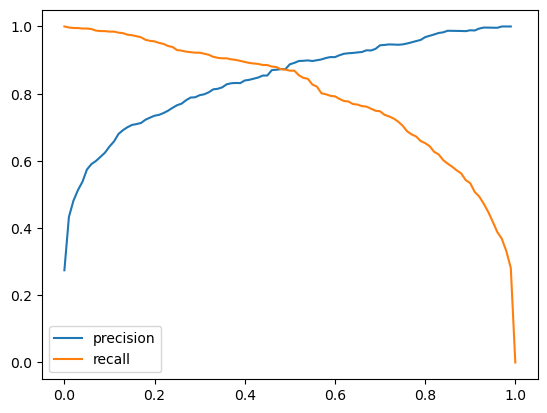

In [22]:
plt.plot(thresholds, precision_list, label='precision')
plt.plot(thresholds, recall_list, label='recall')

plt.legend()

plt.show()

### Q4: F1 Score

In [23]:
thresholds = np.linspace(0, 1, 101)

In [24]:
f1_score = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (lr.predict_proba(X_val)[:, 1] >= t)
    predict_negative = (lr.predict_proba(X_val)[:, 1] < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * precision * recall / (precision + recall)

    f1_score.append(f1)

C:\Users\PC\AppData\Local\Temp\ipykernel_23316\2769231596.py:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


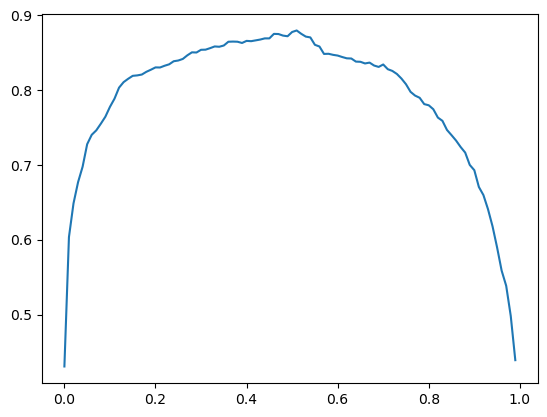

In [25]:
plt.plot(thresholds, f1_score, label='f1_score');

In [26]:
# maximum f1 score threshold value

thresholds[f1_score.index(max(f1_score))]

0.51

### Q5: 5-Fold CV

In [27]:
def train(X_train, y_train, C=1.0):
    dicts = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [28]:
def predict(X, dv, model):
    dicts = X.to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [30]:
score = []

for train_idx, val_idx in tqdm(KFold(n_splits=5, shuffle=True, random_state=1).split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_target.values
    y_val = df_val.above_target.values

    dv, model = train(df_train.drop('above_target', axis=1), y_train, C=1.0)

    y_pred = predict(df_val.drop('above_target', axis=1), dv, model)

    auc = roc_auc_score(y_val, y_pred)

    score.append(auc)

0it [00:00, ?it/s]

In [31]:
round(np.std(score), 3)

0.003

### Q6: Hyperparameter Tuning

In [32]:
c_list = [0.01, 0.1, 0.5, 10]

In [33]:
c_score = {c: [] for c in c_list}

for c in tqdm(c_list):

    for train_idx, val_idx in tqdm(KFold(n_splits=5, shuffle=True, random_state=1).split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_target.values
        y_val = df_val.above_target.values

        dv, model = train(df_train.drop('above_target', axis=1), y_train, C=c)

        y_pred = predict(df_val.drop('above_target', axis=1), dv, model)

        auc = roc_auc_score(y_val, y_pred)

        c_score[c].append(auc)

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [34]:
for c, score in c_score.items():
    print(c, round(np.mean(score), 3), round(np.std(score), 3))

0.01 0.952 0.003
0.1 0.972 0.002
0.5 0.978 0.001
10 0.981 0.003
